In [1]:
import numpy as np # linear algebra
import umap
import collections
import os
from tqdm import tqdm
from sklearn.preprocessing import PowerTransformer
import seaborn as sns
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import KMeans
from functions import *
import plotly.graph_objects as go
from sklearn import linear_model
from pandas.core.common import flatten
import math
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

#Focntion pour afficher des information sur le DataSET 
def information (df) :
    print('***************')
    print(df.shape)
    print(df.columns)
    print(df.info())
    print(df.isna().sum())


In [2]:
#Lecture du Fichier
df = pd.read_csv('movie_metadata.csv', sep = ',', encoding='UTF-8')

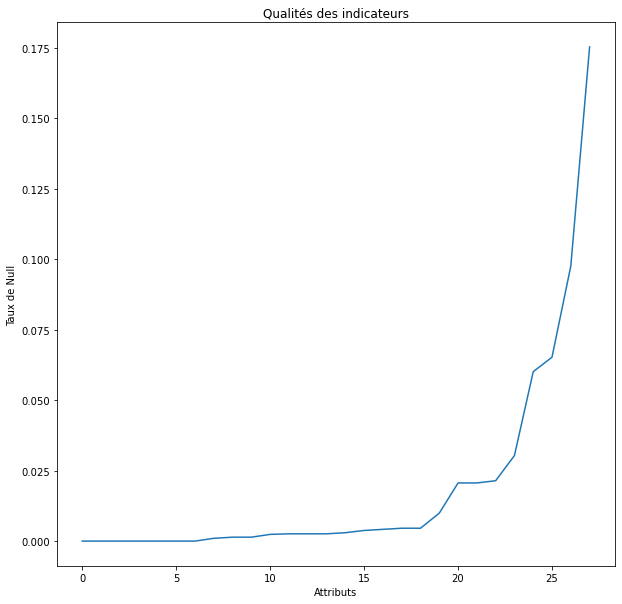

In [4]:
#Affichage d'une courbe de remplissage des attributs
indAvg = df.isna().mean().sort_values()
plt.figure(figsize=(10,10))
plt.plot(range(indAvg.shape[0]),indAvg.values)
plt.xlabel('Attributs')
plt.ylabel('Taux de Null')
plt.title('Qualités des indicateurs')
plt.show()

<AxesSubplot:>

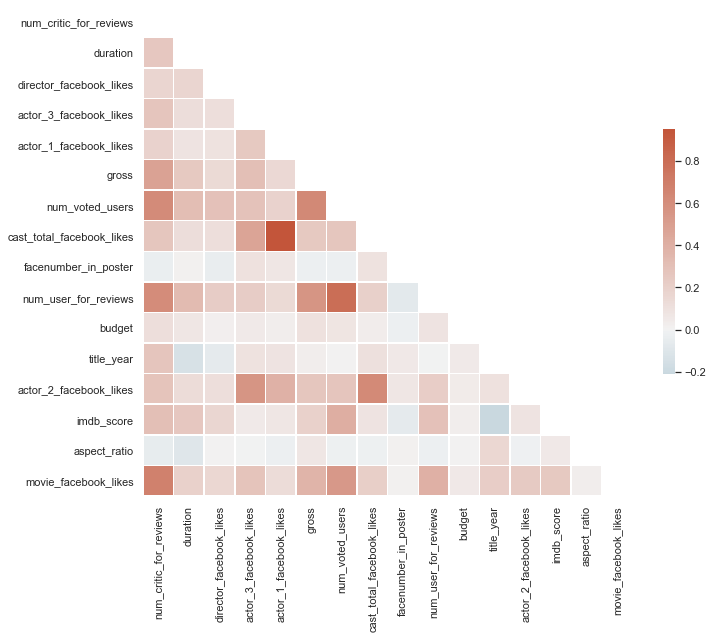

In [5]:
#Graphique de corrélation entre les variables
sns.set_theme(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [3]:
#Suppression des colonnes inutiles
df_clean = df.drop(["facenumber_in_poster", "aspect_ratio","actor_3_facebook_likes","movie_imdb_link","aspect_ratio","gross"], axis=1)

#Suppression des doublons sur le titre du film
df_clean = df_clean.drop_duplicates(subset='movie_title')

In [4]:
#Regression linéaire pour l'imputation des valeurs manquantes
regr = linear_model.LinearRegression()

# Traitement de la variable num_critic_for_reviews
# on utilise seulement 3 variables correlées
if df_clean['num_critic_for_reviews'].isna().sum() > 0 :
    X = df_clean.loc[df_clean['num_critic_for_reviews'].notna() 
                 & df_clean['movie_facebook_likes'].notna() 
                 & df_clean['num_voted_users'].notna() 
                 & df_clean['num_user_for_reviews'].notna(),['movie_facebook_likes','num_voted_users','num_user_for_reviews']]
    Y = df_clean.loc[df_clean['num_critic_for_reviews'].notna(),'num_critic_for_reviews']
    regr.fit(X, Y)

    #précision du modèle
    precision = regr.score(X, Y)
    print('Précision de la Régression : ',precision)
    #Imputation de la variable avec la regression lineaire.
    df_clean.loc[df_clean['num_critic_for_reviews'].isna() 
                                & df_clean['movie_facebook_likes'].notna() 
                                & df_clean['num_voted_users'].notna() 
                                & df_clean['num_user_for_reviews'].notna(), ['num_critic_for_reviews']] = regr.predict(df_clean.loc[df_clean['num_critic_for_reviews'].isna() 
                                & df_clean['movie_facebook_likes'].notna() 
                                & df_clean['num_voted_users'].notna() 
                                & df_clean['num_user_for_reviews'].notna(),['movie_facebook_likes','num_voted_users','num_user_for_reviews']])


Précision de la Régression :  0.5970127208403377


In [5]:
if df_clean['actor_1_facebook_likes'].isna().sum() > 0 :
    
    # on utilise seulement 1 variables fortement correlée
    X = np.array(df_clean.loc[df_clean['actor_1_facebook_likes'].notna(),'cast_total_facebook_likes']).reshape(-1,1)
    Y = df_clean.loc[df_clean['actor_1_facebook_likes'].notna(),'actor_1_facebook_likes']

    regr.fit(X, Y)

    #précision du modèle
    precision = regr.score(X, Y)
    print('Précision de la Régression : ',precision)

    #Imputation de la variable avec la regression lineaire.
    df_clean.loc[df_clean['actor_1_facebook_likes'].isna(), ['actor_1_facebook_likes']] = regr.predict(df_clean.loc[df_clean['actor_1_facebook_likes'].isna() ,['cast_total_facebook_likes']])

# Traitement de la variable actor_2_facebook_likes et actor_1_facebook_likes
if df_clean['actor_2_facebook_likes'].isna().sum() > 0 :
   
    # on utilise seulement 1 variables fortement correlée
    X = np.array(df_clean.loc[df_clean['actor_2_facebook_likes'].notna(),'cast_total_facebook_likes']).reshape(-1,1)
    Y = df_clean.loc[df_clean['actor_2_facebook_likes'].notna(),'actor_2_facebook_likes']

    regr.fit(X, Y)

    #précision du modèle
    precision = regr.score(X, Y)
    print('Précision de la Régression : ',precision)

    #Imputation de la variable avec la regression lineaire.
    df_clean.loc[df_clean['actor_2_facebook_likes'].isna(), ['actor_2_facebook_likes']] = regr.predict(df_clean.loc[df_clean['actor_2_facebook_likes'].isna() ,['cast_total_facebook_likes']])

Précision de la Régression :  0.9087709915358657
Précision de la Régression :  0.38618000152649645


In [7]:
#Imputation de l'année avec la médiane
df_clean.loc[df_clean['title_year'].isna(),'title_year'] = df_clean['title_year'].median()

#Imputation du budget avec la médiane
df_clean.loc[df_clean['budget'].isna(),'budget'] = df_clean['budget'].median()

#Imputation du num_critic_for_reviews avec la médiane
df_clean.loc[df_clean['num_critic_for_reviews'].isna(),'num_critic_for_reviews'] = df_clean['num_critic_for_reviews'].median()

#Imputation du duration avec la médiane
df_clean.loc[df_clean['duration'].isna(),'duration'] = df_clean['duration'].median()

#Imputation du duration avec la médiane
df_clean.loc[df_clean['num_user_for_reviews'].isna(),'num_user_for_reviews'] = df_clean['num_user_for_reviews'].median()

#Imputation du Director_Facebook_like avec la médiane
df_clean.loc[df_clean['director_facebook_likes'].isna(),'director_facebook_likes'] = df_clean['director_facebook_likes'].median()

#Mise à vide des colors avec NAN
df_clean.rename(columns = {'color' : 'Couleur'}, inplace=True)
df_clean.loc[df_clean['Couleur'].isna(),'Couleur'] = 'VIDE'

#Mise à vide des colors avec NAN
df_clean.loc[df_clean['plot_keywords'].isna(),'plot_keywords'] = 'VIDE'

#Mise à vide des language avec NAN et renommage
df_clean.rename(columns = {'language' : 'VersionOriginale'}, inplace=True)
df_clean.loc[df_clean['VersionOriginale'].isna(),'VersionOriginale'] = 'VIDE'

#Mise à vide des Director avec NAN
df_clean.loc[df_clean['director_name'].isna(),'director_name'] = 'VIDE'

#Mise à vide des Actor_1 avec NAN
df_clean.loc[df_clean['actor_1_name'].isna(),'actor_1_name'] = 'VIDE'

#Mise à vide des Actor_1 avec NAN
df_clean.loc[df_clean['actor_2_name'].isna(),'actor_2_name'] = 'VIDE'

#Mise à vide des Actor_1 avec NAN
df_clean.loc[df_clean['actor_3_name'].isna(),'actor_3_name'] = 'VIDE'

#Mise à vide des content_rating avec NAN
df_clean.loc[df_clean['content_rating'].isna(),'content_rating'] = 'VIDE'

In [8]:
#Utilisation de la colonne Genre : Mise à plat de la liste des genres, création des colonnes
flat_list = list(flatten(df_clean['genres'].str.split('|').tolist()))
for c in set(flat_list) :
    df_clean.loc[df_clean.genres.str.contains(c),c]=1

#Utilisation de la colonne color : Mise à plat de la liste des couleurs, création des colonnes
flat_list = list(flatten(df_clean['Couleur'].str.split('|').tolist()))
for c in set(flat_list) :
    df_clean.loc[df_clean.Couleur.str.contains(c),c.strip()]=1 
    
#Utilisation de la colonne Content Rating : Mise à plat de la liste, création des colonnes
flat_list = list(flatten(df_clean['content_rating'].str.split('|').tolist()))
for c in set(flat_list) :
    df_clean.loc[df_clean.content_rating.str.contains(c),c.strip()]=1 

In [9]:
#Utilisation de la language. Il y a 48 languages différents.
#Nous allons supprimer les langues présentes 1 seule fois

#Récupération de la liste
flat_list = list(flatten(df_clean['VersionOriginale']))

#Construction d'un Dataframe pour compter le nombre d'occurence par mot clé
resultat =  pd.DataFrame(columns=['NbreOccurence'])
for c in set(flat_list) :
    resultat.loc[c] = df_clean.VersionOriginale.str.contains(c).sum()

#Suppression des langues présentes 1 seule fois
resultat.drop(resultat[resultat['NbreOccurence'] < 2 ].index, inplace=True)

#Ajout des colonnes Langues
for c in resultat.index :
    df_clean.loc[df_clean.VersionOriginale.str.contains(c),c.strip()]=1  

In [10]:
#Utilisation de la colonne Plot Keywords. Il y a plus de 8000 mots ce qui semble inexploitable.
#Nous allons donc trouver les mots clés les plus utilisés

#Récupération de la liste
flat_list = list(flatten(df_full_cat['plot_keywords'].str.split('|')))

#Construction d'un Dataframe pour compter le nombre d'occurence par mot clé
resultat =  pd.DataFrame(columns=['NbreOccurence'])
for c in set(flat_list) :
    resultat.loc[c] = df_full_cat.plot_keywords.str.contains(c).sum()

#Suppression des mots clés présents moins de 100
resultat.drop(resultat[resultat['NbreOccurence'] < 100 ].index, inplace=True)
    
for c in resultat.index :
    df_full_cat.loc[df_full_cat.plot_keywords.str.contains(c),c.strip()]=1
    
#Même en limitant le nombre de mots utilisés cette information est dure à exploiter. Il faudrait regrouper les mots par type. 

NameError: name 'df_full_cat' is not defined

In [11]:
#Utilisation de la colonne Directors. Il y a plus de 2000 Directeurs ce qui semble inexploitable.
#Nous allons donc trouver les mots clés les plus utilisés
df_full_cat = df_clean.copy()

#Récupération de la liste
flat_list = list(flatten(df_full_cat['director_name']))

#Construction d'un Dataframe pour compter le nombre d'occurence par mot clé
resultat =  pd.DataFrame(columns=['NbreOccurence'])
for c in set(flat_list) :
    resultat.loc[c] = df_full_cat.director_name.str.contains(c).sum()

#Suppression des directors présent moins de 12
resultat.drop(resultat[resultat['NbreOccurence'] < 12 ].index, inplace=True)

#Ajout des colonnes Directeur
for c in resultat.index :
    df_full_cat.loc[df_full_cat.director_name.str.contains(c),c.strip()]=1  

In [12]:
#Utilisation de la colonne Actor_1 Actor 2 et Actor 3. Il y a plus de 4000 Acteurs ce qui semble inexploitable.
#Nous allons donc trouver les mots clés les plus utilisés

#Récupération de la liste
flat_list = list(flatten(df_full_cat['actor_1_name']))
flat_list.extend(list(flatten(df_full_cat['actor_2_name'])))
flat_list.extend(list(flatten(df_full_cat['actor_3_name'])))


#Construction d'un Dataframe pour compter le nombre d'occurence par acteurs
resultat =  pd.DataFrame(columns=['NbreOccurence'])
for c in set(flat_list) :
    resultat.loc[c] = df_full_cat.actor_1_name.str.contains(c).sum()

#Suppression des Acteurs présent moins de 15
resultat.drop(resultat[resultat['NbreOccurence'] < 15 ].index, inplace=True)

#Ajout des colonnes Acteurs
for c in resultat.index :
    df_full_cat.loc[df_full_cat.actor_1_name.str.contains(c) | df_full_cat.actor_2_name.str.contains(c) | df_full_cat.actor_3_name.str.contains(c),c.strip()]=1

In [13]:
#Suppression des colonnes catégorielles qui ont été exploiées
df_clean.drop(columns=["Couleur", "genres",'plot_keywords','VersionOriginale','VIDE','director_name','actor_1_name','actor_2_name','actor_3_name','content_rating'],inplace=True)
df_full_cat.drop(columns=["Couleur", "genres",'plot_keywords','VersionOriginale','VIDE','director_name','actor_1_name','actor_2_name','actor_3_name','content_rating'],inplace=True)

#Replamcement des valeurs NA par 0
df_clean= df_clean.fillna(0)
df_full_cat= df_full_cat.fillna(0)

In [19]:
#Préparation pour le KNN
#Suppression des deux dernières colonnes
df_toAnalyse = df_clean.drop(["movie_title",'country'],axis=1).to_numpy()

# Centrage et Réductions afin de ne pas le répéter dans les différents algorithme
std_scale = preprocessing.StandardScaler().fit(df_toAnalyse)
df_CentreReduit = std_scale.transform(df_toAnalyse)

In [26]:
#Algorithme KNN Plus proche voisin de façon BRUT sans ACP
nbrs = NearestNeighbors(n_neighbors=6, algorithm='ball_tree').fit(df_CentreReduit)
dist_KNN_BRUTE, ind_KNN_BRUTE = nbrs.kneighbors(df_CentreReduit)

In [27]:
#ACP pour plus proche voisin avec l'ensemble des données.
# choix du nombre de composantes à calculer
n_comp = 8

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(df_CentreReduit)
X_ACP = pca.transform(df_CentreReduit)

nbrs = NearestNeighbors(n_neighbors=6, algorithm='ball_tree').fit(X_ACP)
dist_KNN_ACP, ind_KNN_ACP = nbrs.kneighbors(X_ACP)

In [28]:
#Algorithme KNN plus proche voisin après T_SNE
from sklearn.manifold import TSNE
tsne = TSNE()
X_TSNE = tsne.fit_transform(df_CentreReduit)

nbrs = NearestNeighbors(n_neighbors=6, algorithm='ball_tree').fit(X_TSNE)
dist_KNN_TSNE, ind_KNN_TSNE = nbrs.kneighbors(X_TSNE)

100%|██████████| 30/30 [00:44<00:00,  1.49s/it]


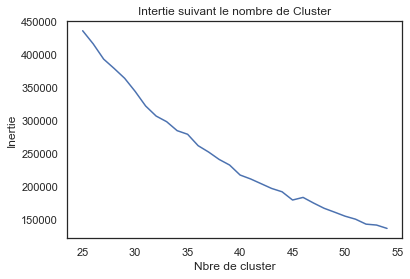

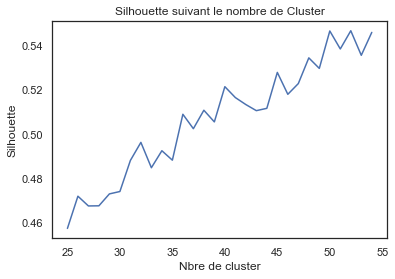

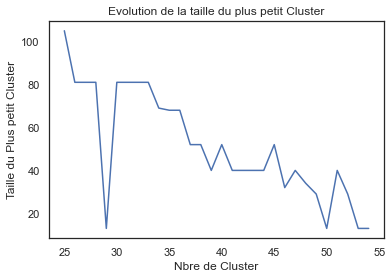

In [28]:
#K-MEANS DETECTION DU NOMBRE DE CLUSTERS POUR TSNE
sse = {}
silhouette_avg = {}
plusPetitCluster = {}
for k in tqdm(range(25, 55)):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_TSNE)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    silhouette_avg[k] = silhouette_score(X_TSNE, kmeans.labels_)
    plusPetitCluster[k] = collections.Counter(kmeans.labels_).most_common()[len(collections.Counter(kmeans.labels_))-1][1]
    
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('Nbre de cluster')
plt.ylabel('Inertie')
plt.title('Intertie suivant le nombre de Cluster')
plt.show()

plt.plot(list(silhouette_avg.keys()),list(silhouette_avg.values()))
plt.xlabel('Nbre de cluster')
plt.ylabel('Silhouette')
plt.title('Silhouette suivant le nombre de Cluster')
plt.show()

plt.plot(list(plusPetitCluster.keys()),list(plusPetitCluster.values()))
plt.xlabel('Nbre de Cluster')
plt.ylabel('Taille du Plus petit Cluster')
plt.title('Evolution de la taille du plus petit Cluster')
plt.show()

100%|██████████| 75/75 [03:06<00:00,  2.48s/it]


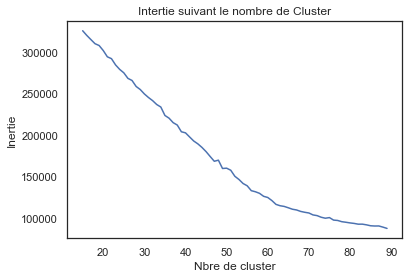

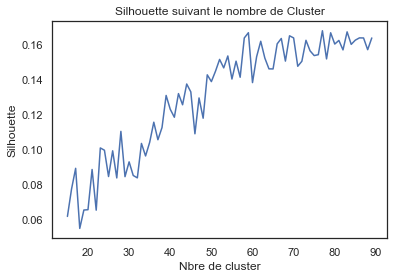

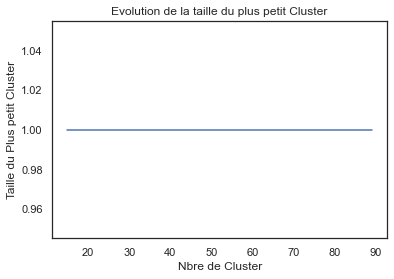

In [29]:
#K-MEANS DETECTION DU NOMBRE DE CLUSTERS POUR DONNEES BRUTES
sse = {}
silhouette_avg = {}
plusPetitCluster = {}
for k in tqdm(range(15, 90)):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_CentreReduit)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    silhouette_avg[k] = silhouette_score(df_CentreReduit, kmeans.labels_)
    plusPetitCluster[k] = collections.Counter(kmeans.labels_).most_common()[len(collections.Counter(kmeans.labels_))-1][1]
    
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('Nbre de cluster')
plt.ylabel('Inertie')
plt.title('Intertie suivant le nombre de Cluster')
plt.show()

plt.plot(list(silhouette_avg.keys()),list(silhouette_avg.values()))
plt.xlabel('Nbre de cluster')
plt.ylabel('Silhouette')
plt.title('Silhouette suivant le nombre de Cluster')
plt.show()

plt.plot(list(plusPetitCluster.keys()),list(plusPetitCluster.values()))
plt.xlabel('Nbre de Cluster')
plt.ylabel('Taille du Plus petit Cluster')
plt.title('Evolution de la taille du plus petit Cluster')
plt.show()

100%|██████████| 18/18 [00:16<00:00,  1.12it/s]


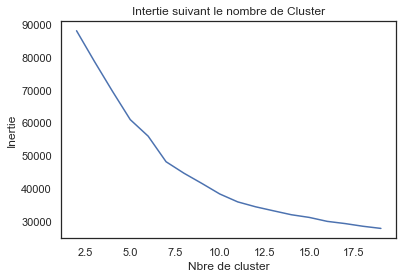

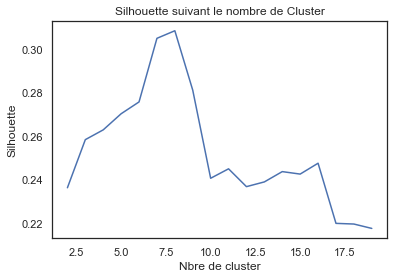

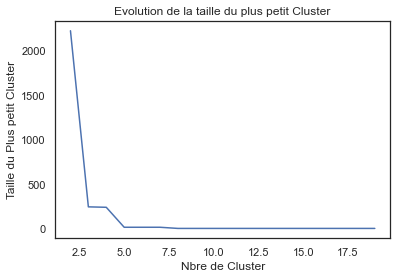

In [30]:
#K-MEANS DETECTION DU NOMBRE DE CLUSTERS POUR DONNEES ACP
sse = {}
silhouette_avg = {}
plusPetitCluster = {}
for k in tqdm(range(2, 20)):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_ACP)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    silhouette_avg[k] = silhouette_score(X_ACP, kmeans.labels_)
    plusPetitCluster[k] = collections.Counter(kmeans.labels_).most_common()[len(collections.Counter(kmeans.labels_))-1][1]
    
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('Nbre de cluster')
plt.ylabel('Inertie')
plt.title('Intertie suivant le nombre de Cluster')
plt.show()

plt.plot(list(silhouette_avg.keys()),list(silhouette_avg.values()))
plt.xlabel('Nbre de cluster')
plt.ylabel('Silhouette')
plt.title('Silhouette suivant le nombre de Cluster')
plt.show()

plt.plot(list(plusPetitCluster.keys()),list(plusPetitCluster.values()))
plt.xlabel('Nbre de Cluster')
plt.ylabel('Taille du Plus petit Cluster')
plt.title('Evolution de la taille du plus petit Cluster')
plt.show()

In [29]:
#Kmeans avec 80 clusters sur Données Brute
kmeans = KMeans(n_clusters=80, max_iter=1000).fit(df_CentreReduit)
kmeans_labels_Brute = kmeans.labels_
print(silhouette_score(df_CentreReduit, kmeans_labels_Brute))

0.16070939116202881


In [30]:
#Kmeans avec 8 clusters sur ACP
kmeans = KMeans(n_clusters=8, max_iter=1000).fit(X_ACP)
kmeans_labels_ACP = kmeans.labels_
print(silhouette_score(X_ACP, kmeans_labels_ACP))

0.3091129568394702


In [31]:
#Kmeans avec 48 clusters sur TSNE
kmeans = KMeans(n_clusters=48, max_iter=1000).fit(X_TSNE)
kmeans_labels_TSNE = kmeans.labels_
print(silhouette_score(X_TSNE, kmeans_labels_TSNE))

0.5366736


In [42]:
#Fonction qui renvoi les films proches pour un film saisi

#Numéro du film saisi
retour = input("Entrez un numéro de film : ")

IdFilm = int(retour)  
#Je vais chercher ses plus proches voisins

#affichage du film en entrée
print('###############')
print('Le film choisi est : ', df_clean.loc[IdFilm,'movie_title'])
print('###############')
print('###############')

filmProche = ind_KNN_BRUTE [IdFilm]
print('############ KNN sur données brute')
print('Les films conseillés sont')
print(df_clean.loc[filmProche[1:7],'movie_title'])

#Avec K-MEANS
print('############ KMEANS données brute')
clusterFilm = kmeans_labels_Brute[IdFilm]
print(df_clean.loc[kmeans_labels_Brute == clusterFilm,'movie_title'].head(7))

filmProche = ind_KNN_ACP [IdFilm]
print('############ KNN après une ACP reduit à 8 Dimensions')
print('Les films conseillés sont')
print(df_clean.loc[filmProche[1:7],'movie_title'])

#Avec K-MEANS
print('############ KMEANS Après ACP')
clusterFilm = kmeans_labels_ACP[IdFilm]
print(df_clean.loc[kmeans_labels_ACP == clusterFilm,'movie_title'].head(7))

filmProche = ind_KNN_TSNE [IdFilm]
print('############ KNN après TSNE')
print('Les films conseillés sont')
print(df_clean.loc[filmProche[1:7],'movie_title'])

#Avec K-MEANS
print('############ KMEANS Après TSNE')
clusterFilm = kmeans_labels_TSNE[IdFilm]
print(df_clean.loc[kmeans_labels_TSNE == clusterFilm,'movie_title'].head(7))

#Avec GOWERS
print('############ GOWERS')
clusterFilm = np.argsort(DistanceTotal[IdFilm])[:6]
print(df_clean.loc[clusterFilm,'movie_title'])

Entrez un numéro de film :  3


###############
Le film choisi est :  The Dark Knight Rises 
###############
###############
############ KNN sur données brute
Les films conseillés sont
97            Inception 
120       Batman Begins 
17         The Avengers 
66      The Dark Knight 
1222    The Other Woman 
Name: movie_title, dtype: object
############ KMEANS données brute
3        The Dark Knight Rises 
66             The Dark Knight 
96                Interstellar 
97                   Inception 
120              Batman Begins 
296           Django Unchained 
308    The Wolf of Wall Street 
Name: movie_title, dtype: object
############ KNN après une ACP reduit à 8 Dimensions
Les films conseillés sont
97                       Inception 
66                 The Dark Knight 
17                    The Avengers 
96                    Interstellar 
433    Hellboy II: The Golden Army 
Name: movie_title, dtype: object
############ KMEANS Après ACP
0                                      Avatar 
1    Pirates of the Caribbea

In [24]:
from sklearn.neighbors import DistanceMetric
from sklearn.preprocessing import MinMaxScaler
#Calcul des distances en prenant en compte les données quantitatives des qualitatives

#indicateurs numériques
indNum = ['num_critic_for_reviews','duration','director_facebook_likes','num_voted_users','cast_total_facebook_likes','budget',
          'title_year','imdb_score','movie_facebook_likes','actor_1_facebook_likes','num_user_for_reviews','actor_2_facebook_likes']

df_Numerique = df_full_cat.loc[:,indNum]
df_Categorie = df_full_cat.drop(indNum,axis=1)
df_Categorie = df_Categorie.drop(["movie_title",'country'],axis=1)

# Centrage et Réductions sur les données numériques
std_scale = preprocessing.StandardScaler().fit(df_Numerique)
df_GowerCentreReduit = std_scale.transform(df_Numerique)

#Calcul de la distance sur les données numériques
DistanceMetrique = DistanceMetric.get_metric('manhattan').pairwise(df_GowerCentreReduit)

# Centrage et Réductions
scaler = MinMaxScaler()
scaler.fit(DistanceMetrique)
DistanceMetrique_CentreReduit = scaler.transform(DistanceMetrique)

#Calcul de la distance sur les données catégorielles
DistanceCategoriel = DistanceMetric.get_metric('dice').pairwise(df_Categorie)

#Calcul de GOWER
#Distance catégoriel + Distance métrique divisé par le nombre de variable
DistanceTotal  = (DistanceCategoriel + DistanceMetrique_CentreReduit) / df_Categorie.shape[1] + df_Numerique.shape[1]

In [40]:
#Ecriture du fichier à exploiter au niveau de l'API
dfForApi = pd.DataFrame(ind_KNN_TSNE)
dfForApi.insert(0, "nomFilm", df['movie_title'], allow_duplicates=False)
dfForApi.to_csv('KNN_BRUTE.csv', sep = '\t', encoding='UTF-8')